# Sales forecasting with Facebook's Prophet

The goal of this notebook is to explore how to leverage [Facebook's Prophet](https://facebook.github.io/prophet/) Python package to create powerful sales forecasts completely within Snowpark.

<b>Forecasting</b> - whether it's sales, demand, supply, or transportation - is a business planning method that helps analysts and planners better anticipate what is going to happen in their business. Depending on the complexity of the business operations, legacy forecasting can be within a handful of spreadsheets, in an ERP planning software (like SAP APO), or as complex as a machine learning model. 

For time-series analyses, several years of historical data is generally required to ensure high accuracy, depending on your situation. If you are forecasting hourly sales at a fast-food restaurant, you may need several months of hourly data to meet requirements. If you are forecasting at a weekly level for store sales, you may need several years of data to appropriately reflect any type of annual seasonality.

Another critical consideration in forecasting is the level of granularity. For example, you may need a sales forecast at both a regional and a store level. Often times, there needs to be a balance between the best level of detail to make decisions off of and how what historical values were regularly measured. As a rule of thumb, it's more accurate to have several specific forecasts (one for each store) and then aggregate up to the bigger picture (sales for all stores) if need be. Creating the underlying forecast at the store level and then aggregating up to the regional level can deliver the best results.

This notebook is leveraging the [Store-Item Demand Forecasting Challenge](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) Kaggle dataset. As a friendly reminder, this dataset is extremely clean, which is not usually the case for real-world forecasting. This dataset only contains historical sales data. While historical trends are generally the strongest indicators of what is to come, other factors, like pricing, promotions, distribution, or macroeconomic factors can influence sales.

<b>Why Facebook Prophet?</b>
Facebook Prophet is a powerful and easy to use time-series package, and you can use it in Snowpark! It does require a lot of historical and stationary data, but it does a great job combining long-term and short-term trends and picks up on seasonality. 

In [1]:
import getpass

pwd = getpass.getpass('Enter password:')

Enter password: ········


In [2]:
import os

os.environ["ACCOUNT"] = "snowdata"
os.environ["USER"] = "AEVANS@PHDATA.IO"
os.environ["ROLE"] = "WS_AEVANS"
os.environ["WAREHOUSE"] = "DEFAULT_USER_WH"
os.environ["DATABASE"] = "USER_AEVANS"
os.environ["SCHEMA"] = "CPG_DEMO_DATA"
os.environ["PRIVATE_KEY_PATH"] = "/Users/andrewevans/.ssh/snowflake_rsa_key.p8"
os.environ["PRIVATE_KEY_PASS"] = pwd

In [3]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import dsa
from cryptography.hazmat.primitives import serialization

with open(os.environ["PRIVATE_KEY_PATH"], "rb") as key:
    p_key= serialization.load_pem_private_key(
        key.read(),
        password=os.environ["PRIVATE_KEY_PASS"].encode(),
        backend=default_backend()
    )
    
pkb = p_key.private_bytes(
    encoding=serialization.Encoding.DER,
    format=serialization.PrivateFormat.PKCS8,
    encryption_algorithm=serialization.NoEncryption())

In [4]:
import snowflake.connector as sc
import snowflake.connector.pandas_tools as pt
from snowflake.connector.pandas_tools import write_pandas

ctx = sc.connect(
    user=os.environ["USER"],
    account=os.environ["ACCOUNT"],
    private_key=pkb,
    warehouse=os.environ["WAREHOUSE"],
    database=os.environ["DATABASE"],
    schema=os.environ["SCHEMA"]
)

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Read in the sales data from local.
import pandas as pd

sales = pd.read_csv('../data/train.csv')
sales.columns = ['DATE','STORE','ITEM','SALES']

In [7]:
from snowflake.snowpark import Session
import os

connection_parameters = {
    "account": os.environ["ACCOUNT"],
    "user": os.environ["USER"],
    "role": os.environ["ROLE"],
    "private_key":pkb,
    "warehouse": os.environ["WAREHOUSE"],
    "database": os.environ["DATABASE"],
    "schema": os.environ["SCHEMA"]
}
session = Session.builder.configs(connection_parameters).create()

In [8]:
from snowflake.snowpark.functions import concat, lit

#load pandas dataframe as a snowpark table
sales_spdf = session.create_dataframe(sales)

# Adjust datatypes
sales_spdf = sales_spdf.withColumn('DATE', sales_spdf.DATE.cast("date"))\
                       .withColumn('STORE', sales_spdf.STORE.cast("string"))\
                       .withColumn('ITEM', sales_spdf.ITEM.cast("string"))

# Create a field for the combination of store-item
sales_spdf = sales_spdf.withColumn('STORE_ITEM', concat(sales_spdf.STORE, lit("_"), sales_spdf.ITEM))

create_temp_table is deprecated. We still respect this parameter when it is True but please consider using `table_type="temporary"` instead.


In [9]:
sales_spdf.show()

----------------------------------------------------------
|"SALES"  |"DATE"      |"STORE"  |"ITEM"  |"STORE_ITEM"  |
----------------------------------------------------------
|13       |2013-01-01  |1        |1       |1_1           |
|11       |2013-01-02  |1        |1       |1_1           |
|14       |2013-01-03  |1        |1       |1_1           |
|13       |2013-01-04  |1        |1       |1_1           |
|10       |2013-01-05  |1        |1       |1_1           |
|12       |2013-01-06  |1        |1       |1_1           |
|10       |2013-01-07  |1        |1       |1_1           |
|9        |2013-01-08  |1        |1       |1_1           |
|12       |2013-01-09  |1        |1       |1_1           |
|9        |2013-01-10  |1        |1       |1_1           |
----------------------------------------------------------



### Exploratory Data Analysis

Before jumping into generating a forecast, let's get familiar with the data. Let's answer some of the following questions:
* How many products are there?
* How many stores are there?
* How many combinations are there?
* How many years of historical data is there? 
* Is the data stationary?

In [10]:
print('There are '+str(sales_spdf.select('STORE').distinct().count())+' unique stores')
print('There are '+str(sales_spdf.select('ITEM').distinct().count())+' unique products')
print('There are '+str(sales_spdf.select('STORE_ITEM').distinct().count())+' unique combinations for store-product')

There are 10 unique stores
There are 50 unique products
There are 500 unique combinations for store-product


In [11]:
#A quick overview
sales_spdf.describe().show()

--------------------------------------------------------------------
|"SUMMARY"  |"SALES"             |"STORE"  |"ITEM"  |"STORE_ITEM"  |
--------------------------------------------------------------------
|count      |913000.0            |913000   |913000  |913000        |
|mean       |52.250287           |NULL     |NULL    |NULL          |
|stddev     |28.801143605766768  |NULL     |NULL    |NULL          |
|min        |0.0                 |1        |1       |10_1          |
|max        |231.0               |9        |9       |9_9           |
--------------------------------------------------------------------



In [12]:
from snowflake.snowpark.functions import when, count, col

#Check for nulls
sales_spdf.select([count(when(col(c).isNull(),c)).alias(c) for c in sales_spdf.columns]).show()

# Turns out that there are no null columns. Great!

------------------------------------------------------
|"SALES"  |"DATE"  |"STORE"  |"ITEM"  |"STORE_ITEM"  |
------------------------------------------------------
|0        |0       |0        |0       |0             |
------------------------------------------------------



In [13]:
historical_size = sales_spdf.select('DATE', 'STORE', 'ITEM').dropDuplicates()\
                            .groupBy('STORE','ITEM').agg(count('*').alias('NUM_DAYS'))

historical_size = historical_size.withColumn('NUM_WEEKS', historical_size.NUM_DAYS / 52)\
                                 .withColumn('NUM_YEARS', historical_size.NUM_DAYS / 365)

In [14]:
historical_size.select('NUM_WEEKS', 'NUM_YEARS').describe().show()

-----------------------------------------
|"SUMMARY"  |"NUM_WEEKS"  |"NUM_YEARS"  |
-----------------------------------------
|count      |500.0        |500.0        |
|stddev     |0.0          |0.0          |
|min        |35.115385    |5.00274      |
|mean       |35.115385    |5.00274      |
|max        |35.115385    |5.00274      |
-----------------------------------------



So far, the data looks very good! The range of sales and general statistics looks pretty reasonable. We have 5 years of historical data available. There are no null values. Now, let's more on and check to see if the data is overall stationary with some graphs

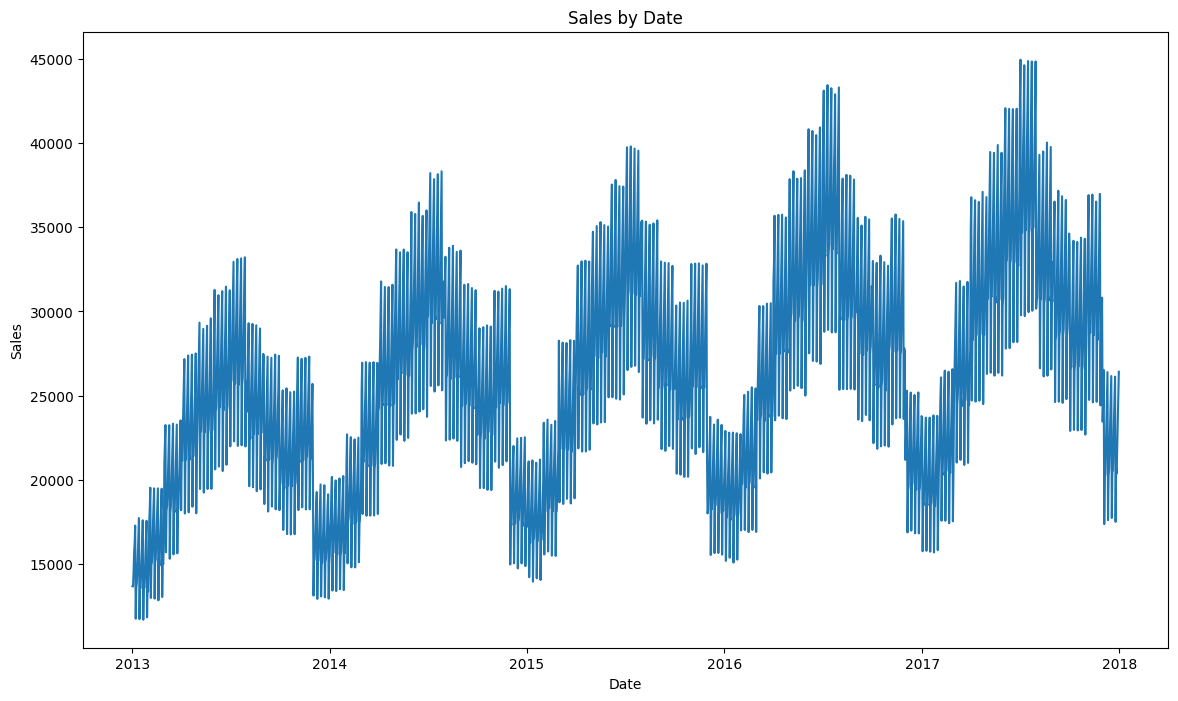

In [15]:
from snowflake.snowpark.functions import sum
import matplotlib.pyplot as plt

# Plot total daily sales
daily_sales = sales_spdf.select('DATE', 'SALES')
daily_sales = daily_sales.groupBy('DATE').agg(sum('SALES').alias('SALES'))\
                         .sort(col('DATE').asc())

plt.figure(figsize=(14,8)) 
plt.plot(daily_sales.to_pandas()['DATE'], daily_sales.to_pandas()['SALES'])
plt.title('Sales by Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

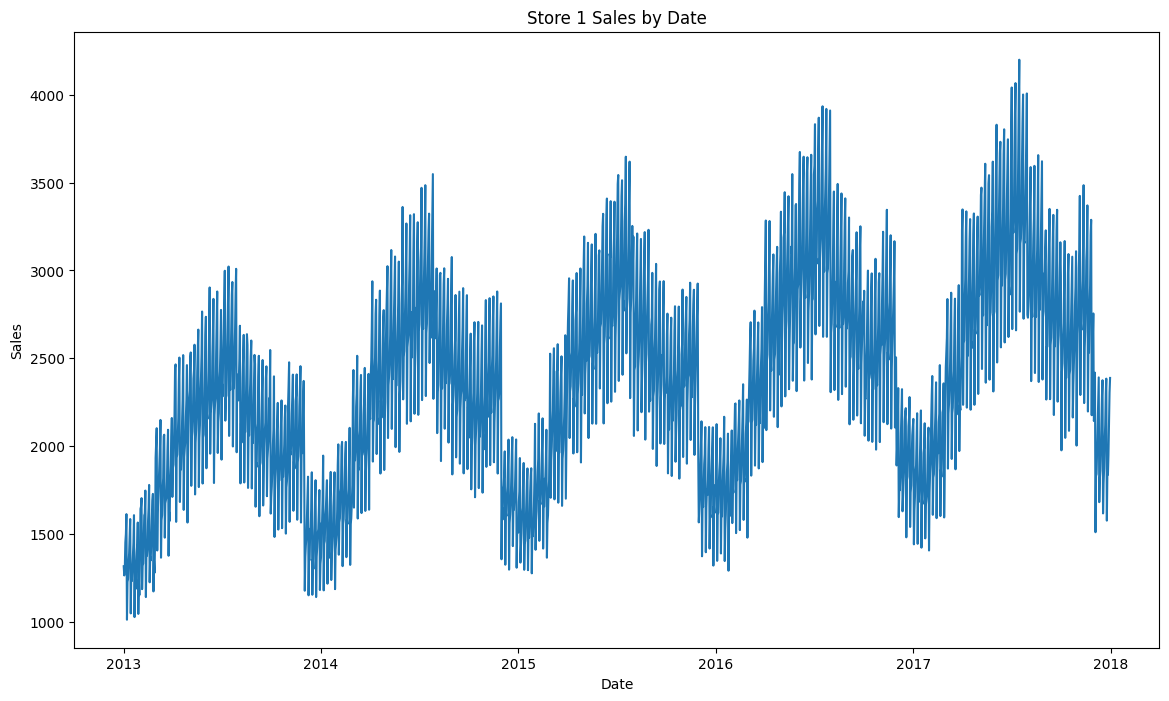

In [16]:
store = '1'

# Plot daily sales by store
daily_sales_store = sales_spdf.select('DATE', 'STORE', 'SALES')
daily_sales_store = daily_sales_store.groupBy('DATE','STORE').agg(sum('SALES').alias('SALES'))\
                         .sort(col('DATE').asc())

filtered_daily_sales_store = daily_sales_store.filter(col('STORE')==store)
plt.figure(figsize=(14,8)) 
plt.plot(filtered_daily_sales_store.to_pandas()['DATE'], filtered_daily_sales_store.to_pandas()['SALES'])
plt.title('Store '+store+' Sales by Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

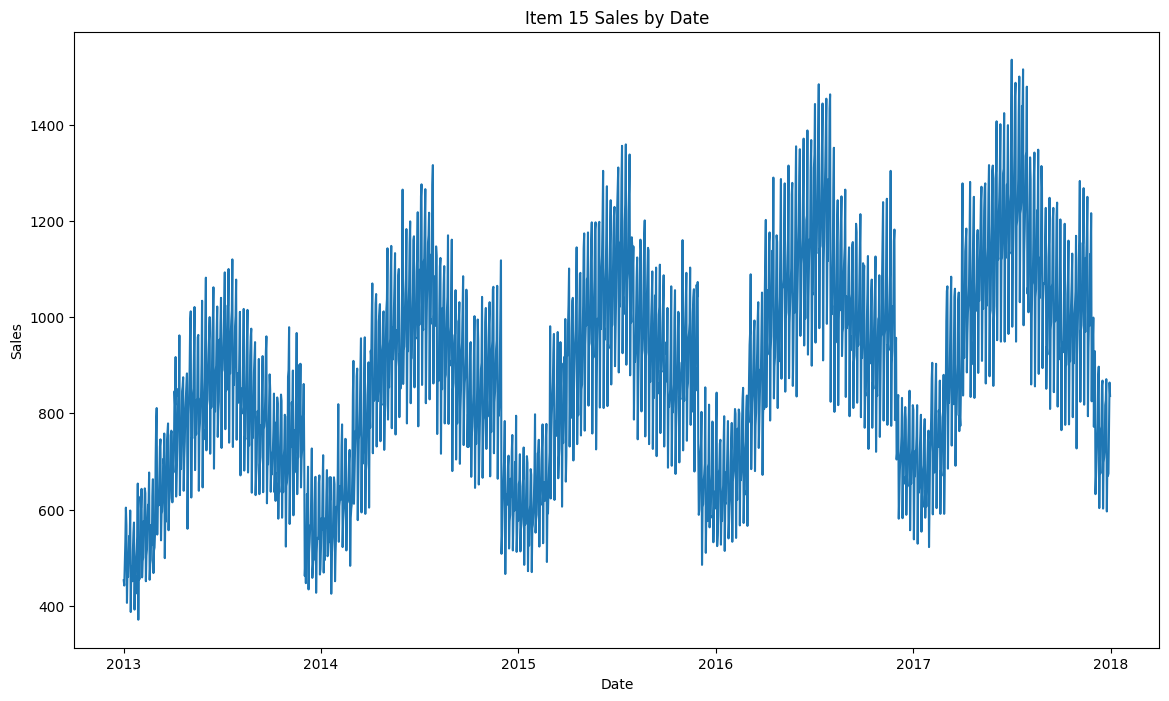

In [17]:
item = '15'

# Plot daily sales - item
daily_sales_item = sales_spdf.select('DATE', 'ITEM', 'SALES')
daily_sales_item = daily_sales_item.groupBy('DATE', 'ITEM').agg(sum('SALES').alias('SALES'))\
                         .sort(col('DATE').asc())

filtered_daily_sales_item = daily_sales_item.filter(col('ITEM')==item)
plt.figure(figsize=(14,8)) 
plt.plot(filtered_daily_sales_item.to_pandas()['DATE'], filtered_daily_sales_item.to_pandas()['SALES'])
plt.title('Item '+item+' Sales by Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

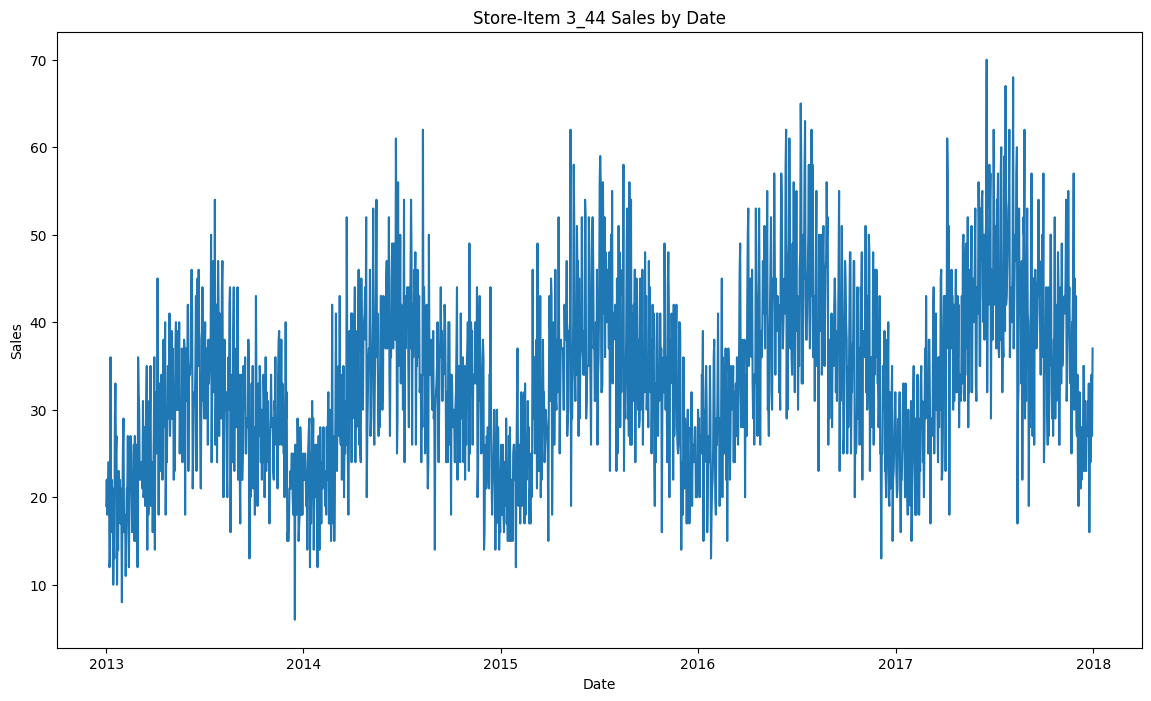

In [18]:
store_item = '3_44'

# Plot daily sales - item
daily_sales_store_item = sales_spdf.select('DATE', 'STORE', 'ITEM', 'STORE_ITEM', 'SALES')
daily_sales_store_item = daily_sales_store_item.groupBy('DATE', 'STORE', 'ITEM', 'STORE_ITEM').agg(sum('SALES').alias('SALES'))\
                         .sort(col('DATE').asc())

filtered_daily_sales_store_item = daily_sales_store_item.filter(col('STORE_ITEM')==store_item)
plt.figure(figsize=(14,8)) 
plt.plot(filtered_daily_sales_store_item.to_pandas()['DATE'], filtered_daily_sales_store_item.to_pandas()['SALES'])
plt.title('Store-Item '+store_item+' Sales by Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

All of the data looks to be stationary, fantastic! Because we have the data to support it, we will build a forecast at the day-store-product level for a 90 day horizon.

## Model building

Since we have ample amount of data for this example, we can forecast at the lowest level of granularity: day-store-item. Even though each combination follows pretty similar patterns, we will still generate a unique forecast for each store-item combination. That's 500 forecasts! Don't worry, it's extremely easy and runs a lot faster than you would expect. 


Let's dive into it!

In [19]:
from snowflake.snowpark.functions import max
from datetime import timedelta  
"""
Because we're going to set a 90 day forecasting horizion, we will determine the split date as 90 days back from the 
max date. Again, we are only doing this to ensure we have labeled data to determine how well our training set does.
You can think of the first 4 years and 9 months are the training set. The testing or holdout set is the last 90 days.
"""

print('The max date is: '+str(sales_spdf.select(max('DATE') ).collect()[0][0]))
print('90 days for testing starts on: '+str(sales_spdf.select(max('DATE') ).collect()[0][0]-timedelta(90)))

The max date is: 2017-12-31
90 days for testing starts on: 2017-10-02


In [20]:
# Prepare the dataframe for modeling 
sales_sub = sales_spdf.select('DATE', 'STORE_ITEM', 'SALES')

# Because the testing dataset doesn't have labels, let's leave out the last 90 days for the testing set
train = sales_sub.filter(col('DATE')<='2017-10-02')

# Combining sales and date columns
train = train.withColumn("DATE_SALES", concat(col('DATE'), lit("_"), col('SALES')))

In [21]:
train.show()

-------------------------------------------------------
|"DATE"      |"STORE_ITEM"  |"SALES"  |"DATE_SALES"   |
-------------------------------------------------------
|2013-01-01  |1_1           |13       |2013-01-01_13  |
|2013-01-02  |1_1           |11       |2013-01-02_11  |
|2013-01-03  |1_1           |14       |2013-01-03_14  |
|2013-01-04  |1_1           |13       |2013-01-04_13  |
|2013-01-05  |1_1           |10       |2013-01-05_10  |
|2013-01-06  |1_1           |12       |2013-01-06_12  |
|2013-01-07  |1_1           |10       |2013-01-07_10  |
|2013-01-08  |1_1           |9        |2013-01-08_9   |
|2013-01-09  |1_1           |12       |2013-01-09_12  |
|2013-01-10  |1_1           |9        |2013-01-10_9   |
-------------------------------------------------------



In [22]:
#now we will make and register a udf for the model training and inference
import pandas as pd
from prophet import Prophet

session.add_packages("pandas", "prophet")

In [23]:
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import ArrayType, StringType

@udf(name='prophet_fit', input_types=[ArrayType(StringType())], return_type=ArrayType(StringType()), is_permanent=False, replace=True)
def prophet_fit(ds_y: list) -> list:
    
    #splitting column into dates and values
    df = pd.DataFrame({'ds_y':ds_y}).ds_y.str.split('_',expand=True)
    df.columns = ['ds', 'y']
    df.ds = pd.to_datetime(df.ds)
    df.y = df.y.astype(int)
    
    
    # Enable daily sesanality since we are dealing with daily data
    m = Prophet(daily_seasonality=True)
    # Prophet has a built-in feature to easily add US holidays, so we will add that as a regressor
    m.add_country_holidays(country_name='US')
    
    # Now we fit the model
    m.fit(df)
    
    # This next step created a future facing data frame for 90 occurances (periods) at the daily level (freq)
    future = m.make_future_dataframe(periods=90, freq='d')
    
    forecast = m.predict(future)
    
    
    return forecast.ds.astype(str)+"_"+forecast.yhat.astype(str)+"_"+forecast.yhat_lower.astype(str)+"_"+forecast.yhat_upper.astype(str)

In [24]:
from snowflake.snowpark.functions import array_agg

#Aggregate training data by store-item
train_rotated = train.groupBy('STORE_ITEM').agg([array_agg(col('DATE_SALES')).alias("ALL_DATE_SALES")])

#Run forecast
forecasts = train_rotated.withColumn('FORECAST', prophet_fit('ALL_DATE_SALES')).select('STORE_ITEM','FORECAST').cache_result()

In [25]:
from snowflake.snowpark.functions import split
from snowflake.snowpark.functions import abs
#Separate forecast values out
flat_forecasts = forecasts.join_table_function("flatten", col("FORECAST")).select('STORE_ITEM','VALUE').withColumn('FORECASTS', split(col("VALUE"), lit("_")))

final_forecasts = flat_forecasts.select('STORE_ITEM', flat_forecasts['FORECASTS'][0], flat_forecasts['FORECASTS'][1], flat_forecasts['FORECASTS'][2], flat_forecasts['FORECASTS'][3])\
                                .toDF(["STORE_ITEM","DATE","YHAT","YHAT_LOWER","YHAT_UPPER"])\
                                .withColumn("DATE", col('DATE').cast("date"))\
                                .withColumn("YHAT", col('YHAT').cast("float"))\
                                .withColumn("YHAT_LOWER", col('YHAT_LOWER').cast("float"))\
                                .withColumn("YHAT_UPPER", col('YHAT_UPPER').cast("float"))

In [26]:
#Join back the actual sales values
final_forecasts = final_forecasts.join(sales_sub, using_columns=['STORE_ITEM', 'DATE'], join_type='left')

#Calculate forecast errors
final_forecasts = final_forecasts.withColumn("ERROR", col('SALES')-col('YHAT'))\
                                 .withColumn("ABS_ERROR", abs(col('ERROR')))

In [27]:
#Add a column that marks whether the row would be in train or test
final_forecasts = final_forecasts.withColumn('EVAL_SET', when(col('DATE') <= "2017-10-02", "TRAIN").otherwise("TEST"))

In [28]:
final_forecasts.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------
|"STORE_ITEM"  |"DATE"      |"YHAT"              |"YHAT_LOWER"        |"YHAT_UPPER"        |"SALES"  |"ERROR"              |"ABS_ERROR"          |"EVAL_SET"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------
|1_1           |2013-01-03  |9.90680011007996    |4.525512978568559   |15.66545859124543   |14       |4.09319988992004     |4.09319988992004     |TRAIN       |
|1_1           |2013-01-18  |11.143840041975015  |5.355044168505643   |16.994314288230132  |7        |-4.1438400419750145  |4.1438400419750145   |TRAIN       |
|1_1           |2013-01-30  |9.79035042138001    |4.0112328377479765  |15.49835113036368   |9        |-0.7903504213800101  |0.7903504213800101   |TRAIN       |
|1_1           |2013-02-07  |10.79666790

In [29]:
final_forecasts.write.mode("overwrite").save_as_table("OUTPUT_FORECASTS")

## Let's take a look at forecast accuracy

Most business define forecast accuracy as a weighted mean average percent error (MAPE).
* Forecast Accuracy = 1 - ( ABS(Predicted - Actuals) / Actuals )

We will use this approach to evaluate our forecast.

In [30]:
# Read in the forecast sales data from Snowflake 
results = session.table("OUTPUT_FORECASTS")
results.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------
|"STORE_ITEM"  |"DATE"      |"YHAT"              |"YHAT_LOWER"        |"YHAT_UPPER"        |"SALES"  |"ERROR"              |"ABS_ERROR"          |"EVAL_SET"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------
|1_1           |2013-01-03  |9.90680011007996    |4.525512978568559   |15.66545859124543   |14       |4.09319988992004     |4.09319988992004     |TRAIN       |
|1_1           |2013-01-18  |11.143840041975015  |5.355044168505643   |16.994314288230132  |7        |-4.1438400419750145  |4.1438400419750145   |TRAIN       |
|1_1           |2013-01-30  |9.79035042138001    |4.0112328377479765  |15.49835113036368   |9        |-0.7903504213800101  |0.7903504213800101   |TRAIN       |
|1_1           |2013-02-07  |10.79666790

In [31]:
results = results.withColumn('STORE', split(col("STORE_ITEM"), lit("_"))[0].cast("string"))\
                 .withColumn('ITEM', split(col("STORE_ITEM"), lit("_"))[1].cast("string"))

results.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"STORE_ITEM"  |"DATE"      |"YHAT"              |"YHAT_LOWER"        |"YHAT_UPPER"        |"SALES"  |"ERROR"              |"ABS_ERROR"         |"EVAL_SET"  |"STORE"  |"ITEM"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|10_17         |2013-11-26  |27.743140970371098  |20.06833845185067   |36.068836286300595  |26       |-1.7431409703710976  |1.7431409703710976  |TRAIN       |10       |17      |
|10_17         |2013-11-27  |27.006297387806086  |19.158335123877418  |35.201449746617826  |29       |1.993702612193914    |1.993702612193914   |TRAIN       |10       |17      |
|10_17         |2013-12-10  |21.399193468824446  |13.09061078501207   |29.798642250230085  |21       |-0.39919

In [32]:
# Aggregate results at an overall level (actuals and predicted)
results_agg = results.select('DATE','SALES','YHAT').groupBy('DATE').agg([sum('YHAT').alias('YHAT'), sum('SALES').alias('SALES')]).sort(col('DATE').asc())
results_agg.show()

---------------------------------------------
|"DATE"      |"YHAT"              |"SALES"  |
---------------------------------------------
|2013-01-01  |11413.03632364976   |13696    |
|2013-01-02  |11717.77771481464   |13678    |
|2013-01-03  |13295.89941481465   |14488    |
|2013-01-04  |15035.286759540899  |15677    |
|2013-01-05  |16735.335932956626  |16237    |
|2013-01-06  |18425.751271393427  |17291    |
|2013-01-07  |8023.193332175544   |11769    |
|2013-01-08  |11416.081739601412  |13560    |
|2013-01-09  |11439.637952277737  |13878    |
|2013-01-10  |13023.626714019912  |14642    |
---------------------------------------------



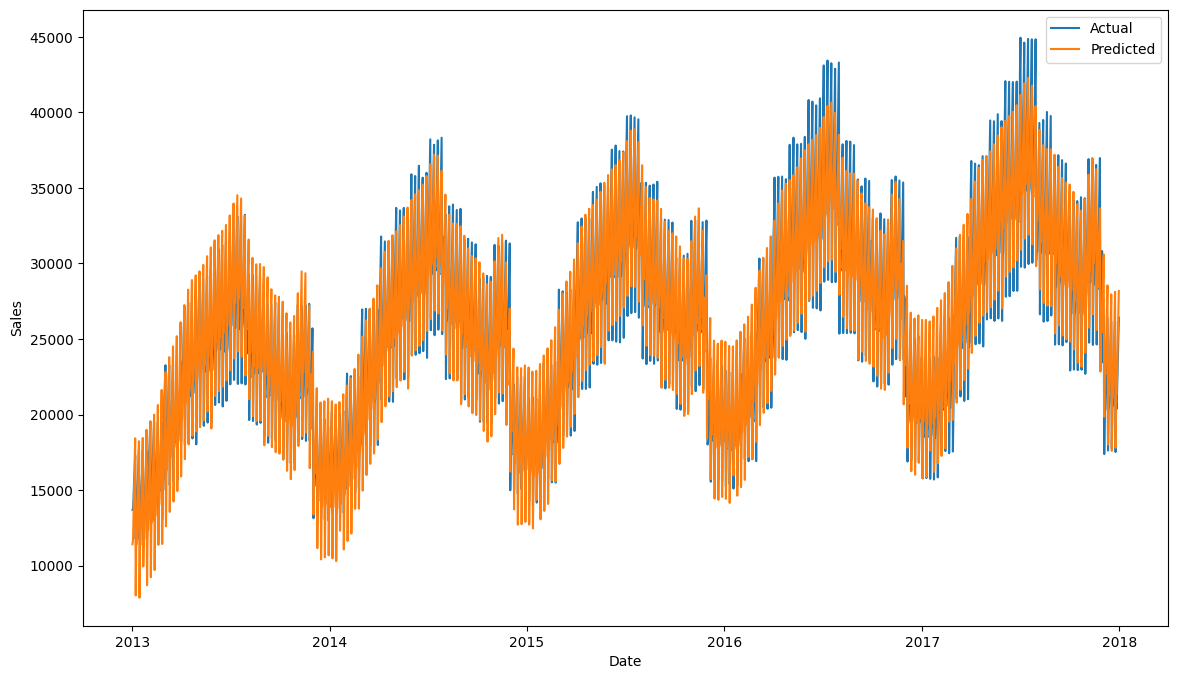

In [33]:
fig,ax = plt.subplots(figsize=(14,8))
ax.plot(results_agg.to_pandas()['DATE'], results_agg.to_pandas()['SALES'])
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.plot(results_agg.to_pandas()['DATE'], results_agg.to_pandas()['YHAT'])
plt.legend(["Actual", "Predicted"])
plt.show()

In [34]:
eval_df = results.filter(col('EVAL_SET')=='TEST')
eval_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"STORE_ITEM"  |"DATE"      |"YHAT"              |"YHAT_LOWER"        |"YHAT_UPPER"        |"SALES"  |"ERROR"               |"ABS_ERROR"          |"EVAL_SET"  |"STORE"  |"ITEM"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|8_34          |2017-10-13  |36.88885293921959   |29.570414086135177  |44.342205819782365  |24       |-12.88885293921959    |12.88885293921959    |TEST        |8        |34      |
|8_34          |2017-10-16  |28.90584773840726   |21.441353910771404  |36.45810028369098   |27       |-1.9058477384072603   |1.9058477384072603   |TEST        |8        |34      |
|8_34          |2017-10-19  |34.41361964846546   |27.119824341432025  |41.24810544530745   |28      

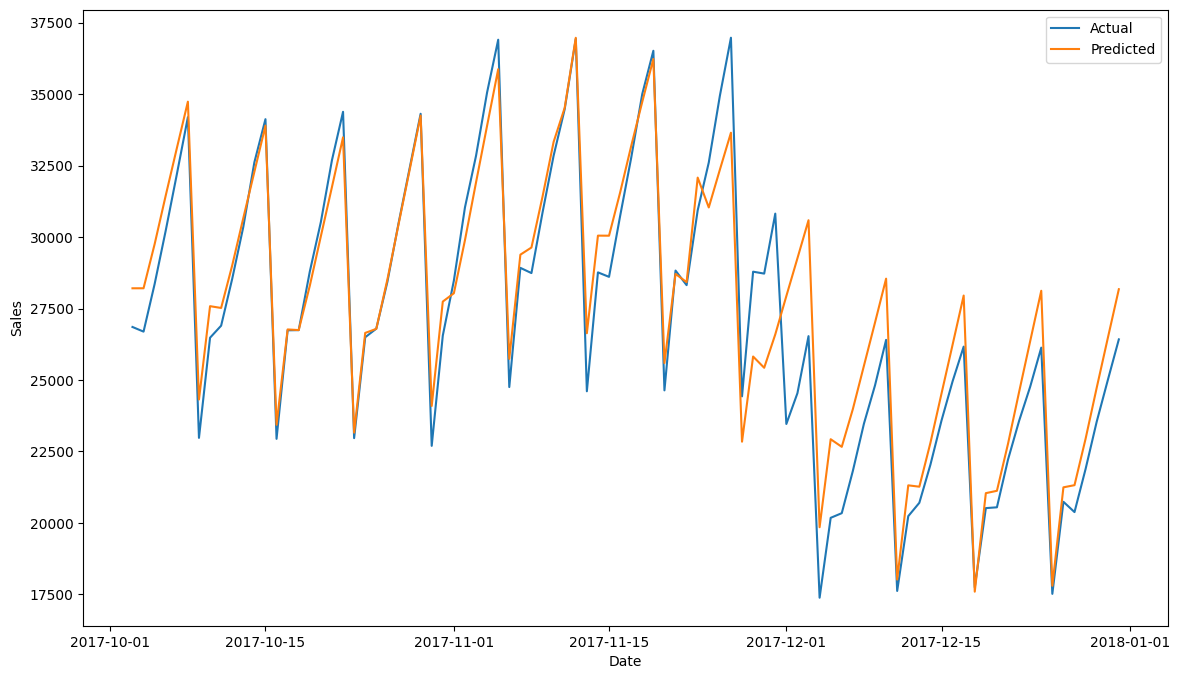

In [35]:
results_agg = eval_df.select('DATE','SALES','YHAT').groupBy('DATE').agg([sum('YHAT').alias('YHAT'), sum('SALES').alias('SALES')]).sort(col('DATE').asc())

fig,ax = plt.subplots(figsize=(14,8))
ax.plot(results_agg.to_pandas()['DATE'], results_agg.to_pandas()['SALES'])
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.plot(results_agg.to_pandas()['DATE'], results_agg.to_pandas()['YHAT'])
plt.legend(["Actual", "Predicted"])
plt.show()

In [36]:
train = results.filter(col('EVAL_SET')=='TRAIN')
print('The forecast accuracy for the training set is: '+str(1-(train.agg(sum('ABS_ERROR')).collect()[0][0]/train.agg(sum('SALES')).collect()[0][0])))

test = results.filter(col('EVAL_SET')=='TEST')
print('The forecast accuracy for the testing set is: '+str(1-(test.agg(sum('ABS_ERROR')).collect()[0][0]/test.agg(sum('SALES')).collect()[0][0])))

The forecast accuracy for the training set is: 0.8880859056403992
The forecast accuracy for the testing set is: 0.8831550053426365


In [37]:
store_item_accuracy = eval_df.select('STORE', 'ITEM', 'SALES', 'YHAT', 'ABS_ERROR')\
                             .groupBy(['STORE', 'ITEM']).agg([sum('ABS_ERROR').alias('ABS_ERROR'), sum('SALES').alias('SALES')])\
                             .withColumn('OVERALL_ACCURACY', lit(1)-(col('ABS_ERROR') / col('SALES')) )
store_item_accuracy.show()

-----------------------------------------------------------------------
|"STORE"  |"ITEM"  |"ABS_ERROR"        |"SALES"  |"OVERALL_ACCURACY"  |
-----------------------------------------------------------------------
|3        |35      |617.1317521237015  |6950     |0.9112040644426329  |
|5        |36      |602.3543460600047  |5540     |0.8912717786895299  |
|7        |36      |559.0392312133816  |5129     |0.8910042442555309  |
|9        |36      |771.8419591912028  |7536     |0.8975793578567937  |
|10       |37      |417.4982857516546  |3092     |0.8649746811928672  |
|1        |38      |786.8040788132016  |6898     |0.8859373617261233  |
|10       |38      |800.9441834158548  |8572     |0.9065627410854112  |
|2        |39      |527.6497631840384  |5183     |0.898196071158781   |
|4        |39      |599.3479365004418  |4404     |0.8639082796320523  |
|3        |37      |438.8922588781812  |3133     |0.8599130996239447  |
----------------------------------------------------------------

In [38]:
# Top 10 store-item combinations by forecast accuracy
store_item_accuracy.sort(col('OVERALL_ACCURACY').desc()).show(10)

-----------------------------------------------------------------------
|"STORE"  |"ITEM"  |"ABS_ERROR"        |"SALES"  |"OVERALL_ACCURACY"  |
-----------------------------------------------------------------------
|2        |22      |673.1945652097269  |9741     |0.9308906102854196  |
|2        |15      |804.605881042823   |10526    |0.923560148105375   |
|10       |28      |733.5611427501808  |9264     |0.9208159388223034  |
|10       |18      |706.8435459417943  |8844     |0.9200764873426284  |
|10       |13      |735.5247932750054  |8994     |0.9182205033049805  |
|2        |18      |858.2824825978536  |10241    |0.9161915357291424  |
|10       |22      |712.3795042843656  |8441     |0.9156048448898987  |
|2        |24      |684.5425637391878  |8093     |0.9154154746399126  |
|9        |28      |745.3352766659225  |8752     |0.9148382910573671  |
|8        |15      |874.5916399587404  |10227    |0.9144820925042788  |
----------------------------------------------------------------

In [39]:
# Last 10 store-item combinations by forecast accuracy
store_item_accuracy.sort(col('OVERALL_ACCURACY').asc()).show(10)

------------------------------------------------------------------------
|"STORE"  |"ITEM"  |"ABS_ERROR"         |"SALES"  |"OVERALL_ACCURACY"  |
------------------------------------------------------------------------
|7        |5       |294.0946047884847   |1200     |0.7549211626762627  |
|7        |27      |323.4634778239702   |1348     |0.7600419303976482  |
|7        |41      |323.90082211839245  |1371     |0.7637484886080288  |
|5        |41      |353.619719675302    |1548     |0.7715634885818463  |
|6        |4       |345.8638716018779   |1564     |0.7788594171343491  |
|5        |27      |342.9190892307248   |1552     |0.7790469785884505  |
|6        |5       |292.4543348774695   |1348     |0.7830457456398594  |
|1        |41      |389.19677603090093  |1853     |0.7899639632860761  |
|5        |47      |335.55827396299367  |1609     |0.791449177151651   |
|7        |4       |294.87981606118205  |1435     |0.7945088389817547  |
---------------------------------------------------

## In summary, leveraging FB Prophet can help your organization create accurate and meaningful forecasts at a granular level. It does a great job picking up seasonality as well as long-term and short-term trends.

Interested in learning more? Contact the [phData Data Science team](https://www.phdata.io/contact-us/) for questions or more information!